In [1]:
import pandas as pd
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta
from datetime import time
from datetime import datetime
from backtesting import Backtest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

In [3]:
def figure(strategy):   

    equity_data = strategy._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
    equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

    ax1.grid(linestyle = '--', linewidth = 1)
    ax1.plot(equity_data['Equity'])
    ax1.set(ylabel="Equity($)")
    ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    ax2.grid(linestyle = '--', linewidth = 1)
    ax2.plot(equity_data['DrawdownPct'], color="red")
    ax2.set(ylabel="DrawdownPct(%)")
    ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   

    date_to_highlight = pd.Timestamp('2023-01-01')
    ax1.axvline(x=date_to_highlight, color='red', linestyle='-')
    ax2.axvline(x=date_to_highlight, color='red', linestyle='-')

    f.subplots_adjust(hspace=0)
    f.autofmt_xdate()
    plt.show()

# 使用5分K、日夜盤

In [4]:
df = pd.read_csv(f"TXF_1T_20240513.csv", index_col=0)

df.index = pd.to_datetime(df.index)

df_5 = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum',
     '大戶買進' :'sum',
     '散戶買進' :'sum',
     '大戶掛單' :'sum',
     '散戶掛單' :'sum'
    })
df_15 = df.resample('15T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum',
     '大戶買進' :'sum',
     '散戶買進' :'sum',
     '大戶掛單' :'sum',
     '散戶掛單' :'sum'
    })

df_5 = df_5.dropna()

df_day = df_5.between_time('08:44:59', '13:45:01') #日盤 樣本內+外

df_day_inner = df_day[df_day.index.year<2023] # 樣本內

df_night_5 = df_5.between_time('14:59:59', '05:00:01') #夜盤 樣本內+外

df_night_5_inner = df_night_5[df_night_5.index.year<2023] # 樣本內


df_15 = df_15.dropna()

df_night_15 = df_15.between_time('14:59:59', '05:00:01') #夜盤 樣本內+外

df_night_15_inner = df_night_15[df_night_15.index.year<2023] # 樣本內


多空結合

In [26]:

class day_buy_sell(Strategy):
    ema_window = 280 # 280
    
    how_much_to_buy = 600
    mom_long = 150
    loss_long  = -580

    how_much_to_sell = -520
    mom_short = -270
    loss_short  = 460

    def init(self):
        self.MA = self.I(ta.MA, self.data.大戶買進, timeperiod=1) # 單純把線畫出來
        self.ema_200 = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_window) # 判斷趨勢
        self.MOM_1 = self.I(ta.MOM, self.data.大戶買進, timeperiod=1) # 計算五分鐘內買了多少

    def next(self):
        if (self.data.index[-1] > pd.Timestamp('2020-03-22 23:00')) and (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() >= time(9, 00)) and not self.position: # 未持倉(9:00 ~ 13:25)
            if self.data.大戶買進[-1] > self.how_much_to_buy and self.data.Close[-1] > self.ema_200[-1] and self.MOM_1[-1] >= self.mom_long:
                self.buy(size=200)

            elif self.data.大戶買進[-1] < self.how_much_to_sell and self.data.Close[-1] < self.ema_200[-1] and self.MOM_1[-1] <= self.mom_short:
                self.sell(size=200)

        elif self.position.is_long and self.MOM_1[-1] <= self.loss_long: # 多單出場
            self.position.close()
        elif self.position.is_short and self.MOM_1[-1] >= self.loss_short: # 空單出場
            self.position.close()

        # 因為要當沖
        if self.position and self.data.index[-1].time() >= time(13, 30) and self.data.index[-1].time() <= time(14, 00):
                self.position.close() #平倉

In [ ]:
# 樣本內+外
bt = Backtest(df_day, day_buy_sell, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
#Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

In [ ]:
figure(stats)

純多單

In [44]:

class dayBuy(Strategy):
    ema_window = 250
    how_much_to_buy = 600
    mom_long = 150
    loss_long  = -580

    def init(self):
        self.MA = self.I(ta.MA, self.data.大戶買進, timeperiod=1)
        self.ema = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_window)
        self.MOM_1 = self.I(ta.MOM, self.data.大戶買進, timeperiod=1) # 五分鐘內買了多少

    def next(self):
        if (self.data.index[-1] > pd.Timestamp('2020-03-22 23:00')) and (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() >= time(9, 00)) and not self.position: # 未持倉(9:00 ~ 13:25)
            if self.data.大戶買進[-1] > self.how_much_to_buy and self.data.Close[-1] > self.ema[-1] and self.MOM_1[-1] >= self.mom_long:
                self.buy(size=200)

        elif self.position.is_long and self.MOM_1[-1] <= self.loss_long: # 多單出場
            self.position.close()

        # 因為要當沖
        if self.position and self.data.index[-1].time() >= time(13, 30) and self.data.index[-1].time() <= time(14, 00):
                self.position.close() #平倉

In [219]:
# 樣本內+外
bt = Backtest(df_day, dayBuy, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
#Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2020-03-22 08:50:00
End                       2024-05-10 13:45:00
Duration                   1510 days 04:55:00
Exposure Time [%]                   29.698645
Equity Final [$]                    601567.15
Equity Peak [$]                      775823.4
Return [%]                           20.31343
Buy & Hold Return [%]              130.086245
Return (Ann.) [%]                     4.73179
Volatility (Ann.) [%]               29.563092
Sharpe Ratio                         0.160057
Sortino Ratio                        0.265913
Calmar Ratio                         0.125731
Max. Drawdown [%]                  -37.634352
Avg. Drawdown [%]                   -4.842791
Max. Drawdown Duration      429 days 04:10:00
Avg. Drawdown Duration       32 days 16:13:00
# Trades                                  642
Win Rate [%]                         45.17134
Best Trade [%]                       1.482421
Worst Trade [%]                     -1.251199
Avg. Trade [%]                    

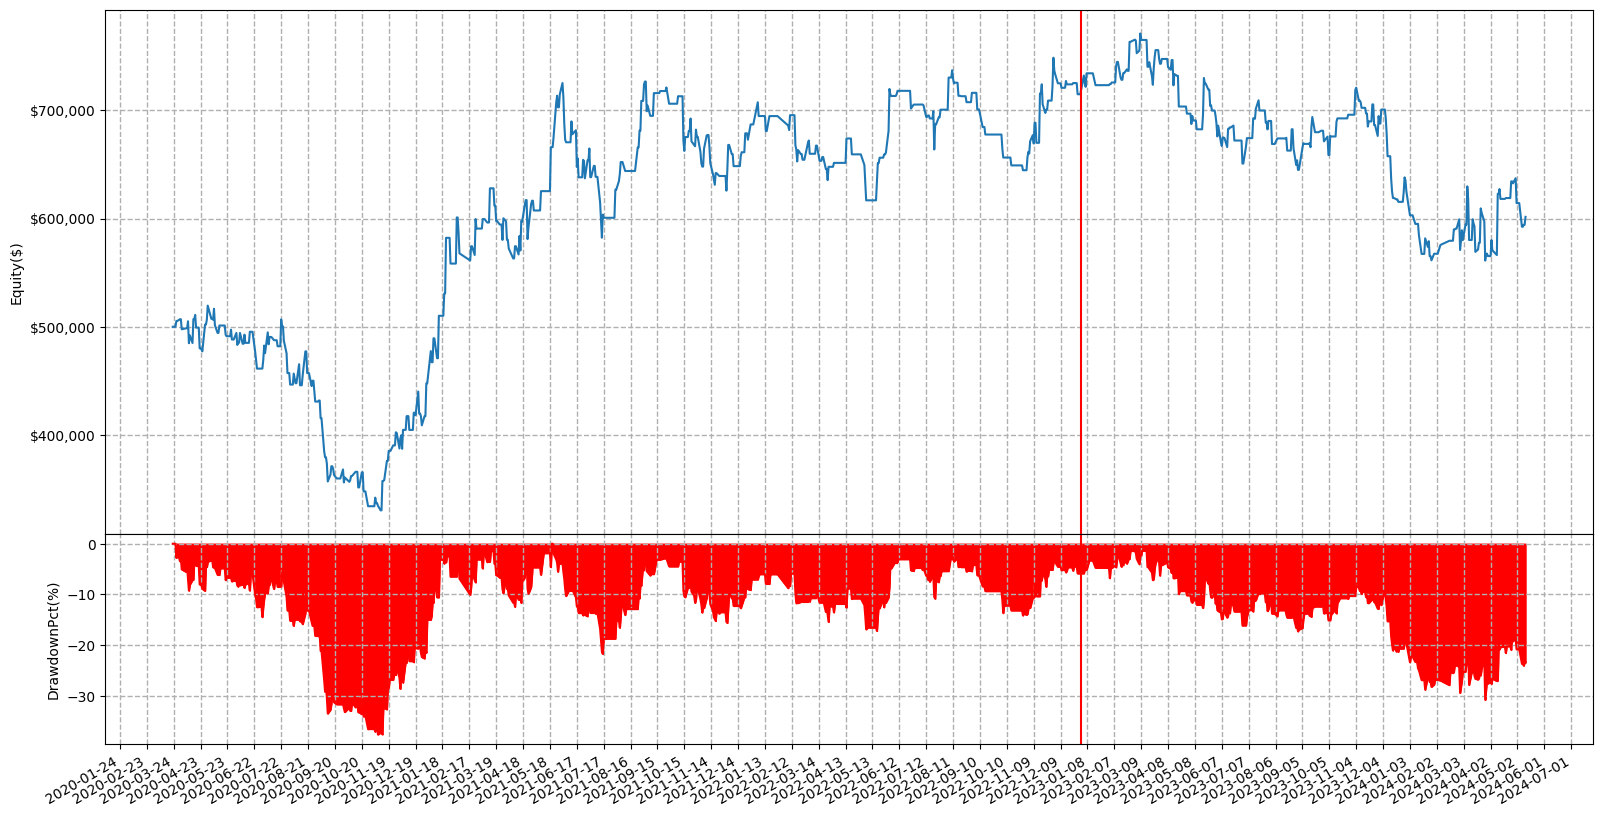

In [220]:
figure(stats)

純空單

In [221]:

class daySell(Strategy):
    ema_window = 280
    how_much_to_sell = -520
    mom_short = -270
    loss_short  = 460

    def init(self):
        self.MA = self.I(ta.MA, self.data.大戶買進, timeperiod=1)
        self.ema = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_window)
        self.MOM_1 = self.I(ta.MOM, self.data.大戶買進, timeperiod=1) # 五分鐘內買了多少

    def next(self):
        if (self.data.index[-1] > pd.Timestamp('2020-03-22 23:00')) and (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() >= time(9, 00)) and not self.position: # 未持倉(9:00 ~ 13:25)
            if self.data.大戶買進[-1] < self.how_much_to_sell and self.data.Close[-1] < self.ema[-1] and self.MOM_1[-1] <= self.mom_short:
                self.sell(size=200)

        if self.position.is_short and self.MOM_1[-1] >= self.loss_short: # 空單出場
            self.position.close()

        # 因為要當沖
        if self.position and self.data.index[-1].time() >= time(13, 30) and self.data.index[-1].time() <= time(14, 00):
                self.position.close() #平倉

In [223]:
# 樣本內+外
bt = Backtest(df_day, daySell, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
#Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2020-03-22 08:50:00
End                       2024-05-10 13:45:00
Duration                   1510 days 04:55:00
Exposure Time [%]                   18.715144
Equity Final [$]                    1032784.0
Equity Peak [$]                     1073360.1
Return [%]                           106.5568
Buy & Hold Return [%]              130.086245
Return (Ann.) [%]                   19.883627
Volatility (Ann.) [%]               31.270275
Sharpe Ratio                         0.635864
Sortino Ratio                        1.435568
Calmar Ratio                         0.490363
Max. Drawdown [%]                  -40.548813
Avg. Drawdown [%]                   -2.935021
Max. Drawdown Duration      420 days 01:40:00
Avg. Drawdown Duration       18 days 17:44:00
# Trades                                  553
Win Rate [%]                        44.303797
Best Trade [%]                       2.453063
Worst Trade [%]                     -1.619717
Avg. Trade [%]                    

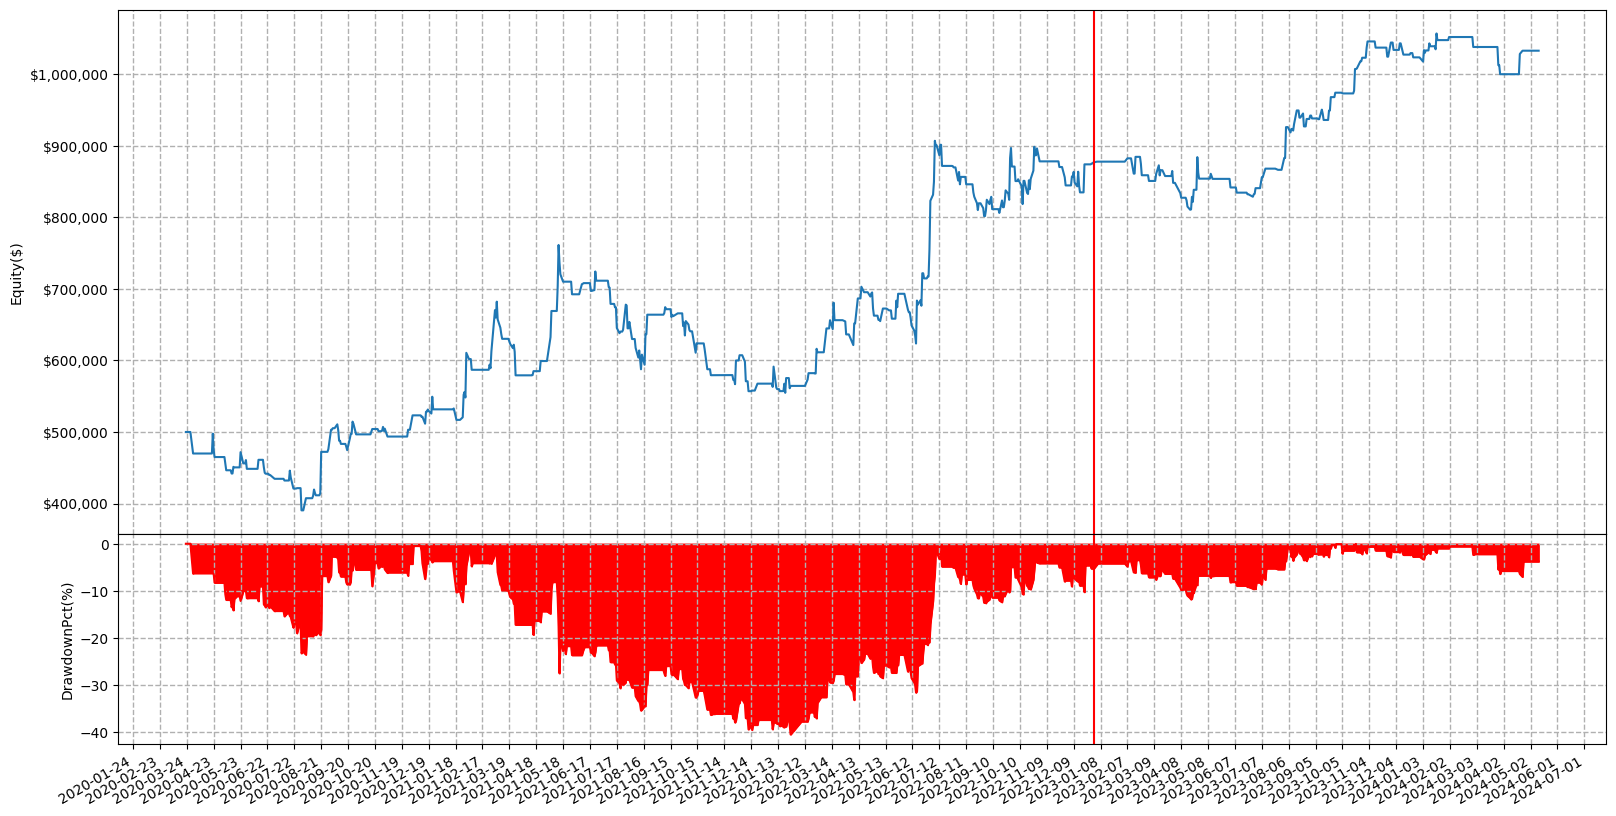

In [224]:
figure(stats)

# NIGHT

多單

In [225]:

class nightBuy(Strategy):
    # ema_window = 240
    how_much_to_buy = 650
    mom_long = 70
    loss_long  = -330
    stop_pct = 9   #表示0.9%

    def init(self):
        self.MA = self.I(ta.MA, self.data.大戶買進, timeperiod=1)
        # self.ema_200 = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_window)
        self.MOM_1 = self.I(ta.MOM, self.data.大戶買進, timeperiod=1) # 五分鐘內買了多少

    def next(self):
        if (self.data.index[-1] > pd.Timestamp('2020-03-23 10:00')) and ((self.data.index[-1].time() >= time(21, 30)) or (self.data.index[-1].time() <= time(4, 00))) and not self.position: # 未持倉(21:30 ~ 4:00)
            if self.data.大戶買進[-1] > self.how_much_to_buy and self.MOM_1[-1] >= self.mom_long: 
                self.buy(size=200)

        elif self.position.is_long:
            if self.MOM_1[-1] <= self.loss_long: # 多單出場
                self.position.close()
            elif self.position.pl_pct < -(self.stop_pct * 0.001): #當前虧損百分比超過停損參數時
                self.position.close() #平倉

        # 因為要當沖
        if self.position and self.data.index[-1].time() >= time(4, 30) and self.data.index[-1].time() <= time(5, 00):
                self.position.close() #平倉

In [227]:
# 樣本內+外
bt = Backtest(df_night_5, nightBuy, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
#Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2020-03-22 15:05:00
End                       2024-05-11 05:00:00
Duration                   1510 days 13:55:00
Exposure Time [%]                    15.55095
Equity Final [$]                     905636.6
Equity Peak [$]                      917685.6
Return [%]                           81.12732
Buy & Hold Return [%]               131.26518
Return (Ann.) [%]                   13.031964
Volatility (Ann.) [%]               19.790023
Sharpe Ratio                         0.658512
Sortino Ratio                        1.155341
Calmar Ratio                          0.75563
Max. Drawdown [%]                    -17.2465
Avg. Drawdown [%]                   -1.223273
Max. Drawdown Duration      350 days 21:45:00
Avg. Drawdown Duration        7 days 00:04:00
# Trades                                  481
Win Rate [%]                        50.935551
Best Trade [%]                       2.633791
Worst Trade [%]                     -1.014301
Avg. Trade [%]                    

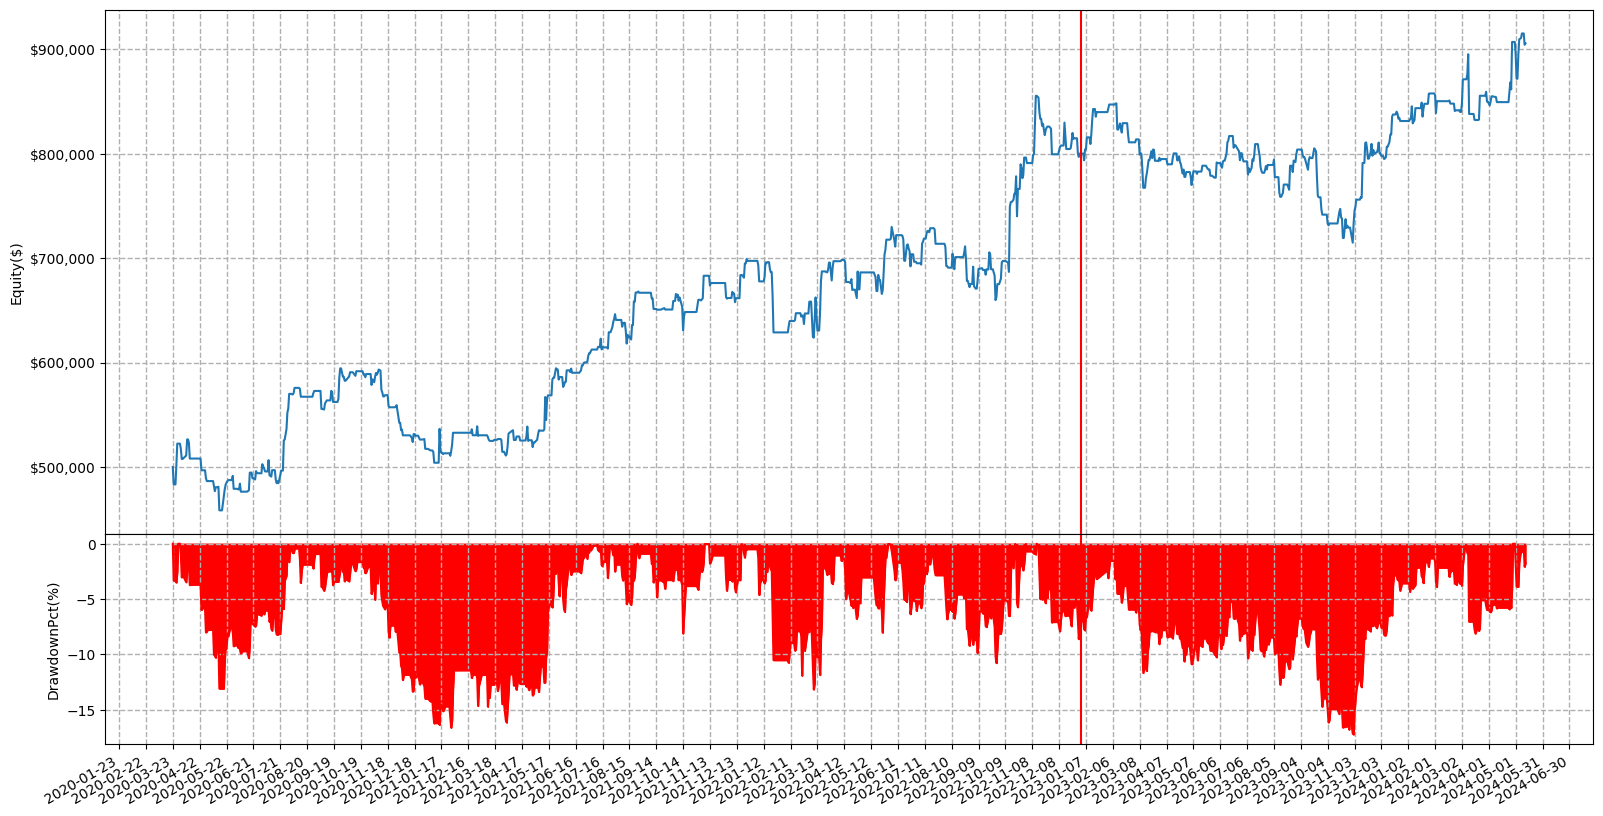

In [228]:
figure(stats)

空單

In [76]:

class nightSell(Strategy):
    ema_window = 5
    how_much_to_sell = -3400
    how_much_to_sell2 = -2600
    mom_short = -950
    a = 3600
    b = 4000
    # mom_short2 = -1400
    loss_short = 525
    # sma_window_slow = 10
    # sma_window_fast = 5
    stop_pct = -0.005   #表示0.9%
    stop_profit = 0.011   #表示0.9%

    def init(self):
        # self.MA = self.I(ta.MA, self.data.大戶買進, timeperiod=1)
        self.ema = self.I(ta.EMA, self.data.Close, timeperiod=self.ema_window)
        self.MOM_1 = self.I(ta.MOM, self.data.大戶買進, timeperiod=1) # 五分鐘內買了多少
        # self.u, self.m, self.l = self.I(ta.BBANDS, self.data.Close, timeperiod=30, nbdevup=2, nbdevdn=2, matype=0) # 布林通道
        # self.sma_slow = self.I(ta.SMA, self.data.Close, timeperiod=self.sma_window_slow)
        # self.sma_fast = self.I(ta.SMA, self.data.Close, timeperiod=self.sma_window_fast)
        # self.rsi = self.I(ta.RSI, self.data.大戶買進, timeperiod=14)
    
    def next(self):
        if (self.data.index[-1] > pd.Timestamp('2020-03-23 10:00')) and ((self.data.index[-1].time() >= time(15, 30)) or (self.data.index[-1].time() <= time(4, 30))) and not self.position: # 未持倉(21:30 ~ 4:00)
            if (self.data.大戶買進[-1] <= self.how_much_to_sell and self.data.散戶買進[-1] <= self.how_much_to_sell2 and self.data.Volume[-1] >= 1200):
                self.sell(size=200)



        elif self.position.is_short:
            # if self.MOM_1[-1] >= self.loss_short: # 空單出場
            #     self.position.close()
            if (self.data.大戶買進[-1] >= self.a and self.data.散戶買進[-1] >= self.b):
            # if (self.data.大戶買進[-1] >= self.a) or (self.MOM_1[-1] > 400):
                self.position.close()
            # elif self.position.pl_pct <= self.stop_pct or self.position.pl_pct >= self.stop_profit:
            if self.position.pl_pct <= self.stop_pct:
                self.position.close()



        # 因為要當沖
        if self.position and self.data.index[-1].time() >= time(4, 30) and self.data.index[-1].time() <= time(5, 00):
                self.position.close() #平倉

# bt = Backtest(df_night_5, nightSell, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
# #Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
# stats = bt.optimize(
#     # rsi_window = range(5, 14, 1),
#     # rsi_overbought = range(80, 90, 2),
#     # rsi_oversold = range(10, 20, 2),
#     # how_nuch_to_buy = range(150, 800, 25),
#     how_much_to_sell = range(-2000, -4000, -200),
#     how_much_to_sell2 = range(-2000, -4000, -200),
#     a = range(2000, 4000, 200),
#     b = range(2000, 5000, 200),
    
#     max_tries = 100,
#     maximize = 'Return [%]'
# )
# print(stats)
# bt.plot(resample=False)

In [77]:
# 樣本內+外
bt = Backtest(df_night_5, nightSell, cash=500000, commission=0.00025, hedging=False, exclusive_orders=False, margin=0.05)
#Backtest(資料名稱, 策略名稱, cash=初始資金, commission=交易成本, hedging=是否優先對之前操作進行抵銷(競賽限定一次只能持有一口), exclusive_orders=每筆新交易是否關閉上一次的交易, margin=初始保證金比例)
stats = bt.run()
print(stats)
# bt.plot(resample=False)

Start                     2020-03-22 15:05:00
End                       2024-05-11 05:00:00
Duration                   1510 days 13:55:00
Exposure Time [%]                    2.092486
Equity Final [$]                     707449.6
Equity Peak [$]                      723935.0
Return [%]                           41.48992
Buy & Hold Return [%]               131.26518
Return (Ann.) [%]                    7.419347
Volatility (Ann.) [%]                8.806903
Sharpe Ratio                         0.842447
Sortino Ratio                        1.675147
Calmar Ratio                         0.538554
Max. Drawdown [%]                   -13.77641
Avg. Drawdown [%]                   -1.323659
Max. Drawdown Duration      508 days 01:55:00
Avg. Drawdown Duration       18 days 23:50:00
# Trades                                   58
Win Rate [%]                        55.172414
Best Trade [%]                       1.579855
Worst Trade [%]                     -0.668974
Avg. Trade [%]                    

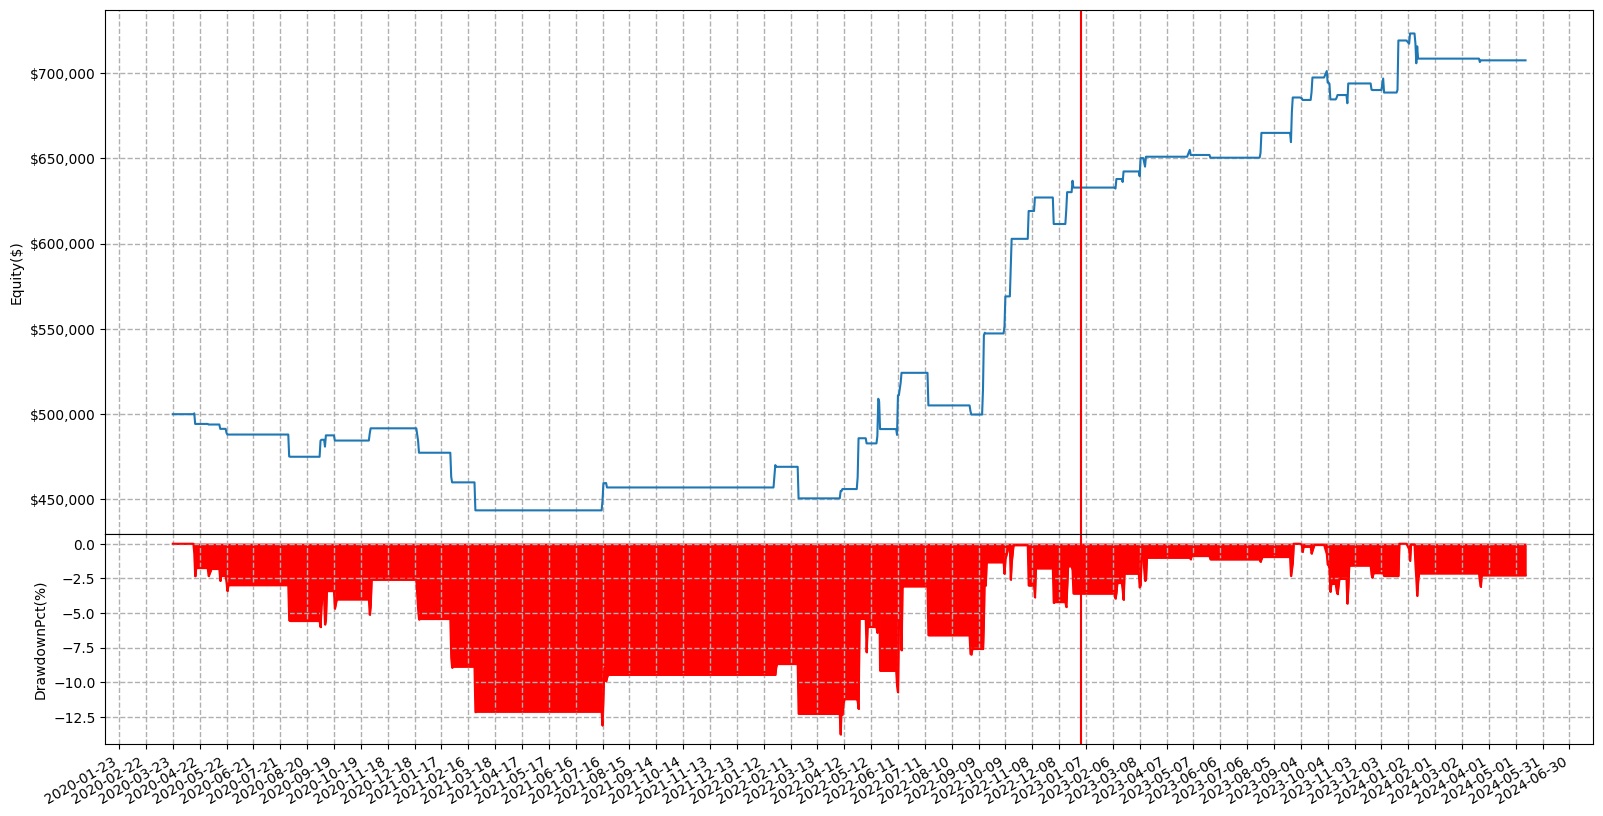

In [78]:
figure(stats)

In [7]:
df_night_inner.iloc[230:260]

,Open,High,Low,Close,Volume,大戶買進,散戶買進,大戶掛單,散戶掛單
2020-03-26 16:45:00,9558.0,9566.0,9549.0,9554.0,310.0,-980.0,-28.0,0.0,-3244.750000
2020-03-26 17:00:00,9553.0,9568.0,9553.0,9567.0,185.0,-770.0,-19.0,0.0,-2898.333333
2020-03-26 17:15:00,9570.0,9581.0,9561.0,9562.0,510.0,-280.0,-32.0,0.0,-1754.485819
2020-03-26 17:30:00,9564.0,9573.0,9558.0,9561.0,252.0,-371.0,-45.0,0.0,-2158.166667
2020-03-26 17:45:00,9560.0,9565.0,9552.0,9561.0,237.0,-861.0,-45.0,0.0,-3750.500000
2020-03-26 18:00:00,9561.0,9573.0,9561.0,9566.0,124.0,-854.0,-45.0,0.0,-3464.666667
2020-03-26 18:15:00,9572.0,9581.0,9567.0,9574.0,269.0,-385.0,-58.0,0.0,-2843.476190
2020-03-26 18:30:00,9573.0,9580.0,9568.0,9580.0,172.0,-616.0,-84.0,0.0,-3646.333333
2020-03-26 18:45:00,9579.0,9629.0,9579.0,9615.0,1535.0,-147.0,308.0,0.0,-831.392877
2020-03-26 19:00:00,9615.0,9623.0,9600.0,9608.0,587.0,77.0,441.0,0.0,722.396763
